In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

import torch 
import torch.nn as nn 
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda')
print('device: ', device)

device:  cuda


In [3]:
def function_2d(x,y):   
    term_sqrt = np.sqrt(x*x+y*y)   
    term1 = np.sin(20*term_sqrt)/(20*term_sqrt)  
    term2 = (1/5)*np.cos(10*term_sqrt)   
    term3 = y/2 - 0.3   

    label = term1 + term2 + term3   

    return label

def generate_data(dim  ):   
    x = np.linspace(-1, 1, dim)  
    y = np.linspace(-1, 1, dim)      
    xx, yy = np.meshgrid(x,y)   
    zz = function_2d(xx,  yy)   
    zz = zz   

    data_1 = xx.reshape(-1,1)   
    data_2 = yy.reshape(-1,1)   
    label = zz.reshape(-1,1)   

    dataset = np.hstack((data_1, data_2))   
    dataset = np.hstack((dataset, label))   
    return dataset

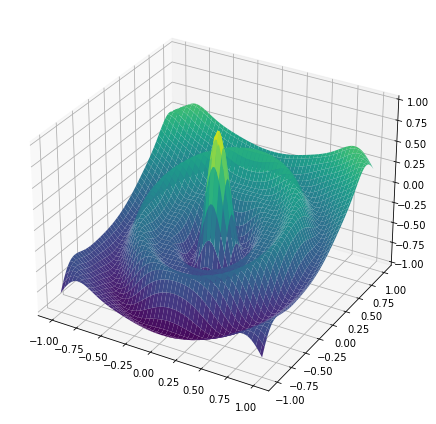

In [4]:
fig = plt.figure(figsize=(9, 6)) 
ax = fig.add_subplot(111, projection='3d') 
x = np.linspace(-1, 1, 100)    
y = np.linspace(-1, 1, 100)    
xx, yy = np.meshgrid(x,y) 
zz = function_2d(xx,yy) 

surf = ax.plot_surface(xx, yy, zz, cmap='viridis')
surf.set_clim(-1.0 , 1.0 ) 
ax.view_init(30,-60) 
ax.set_zticks([-1,1]) 
ax.zaxis.set_major_locator(ticker.MultipleLocator(0.25  )) 
plt.tight_layout() 
plt.show()

In [5]:
class Mydataset(torch.utils.data  .Dataset):     
    def __init__(self, dataX_np , dataY_np):         
        self.data_X = dataX_np.astype(np.float32)        
        self.data_Y = dataY_np.astype(np.float32)        
        
        print(f"My_dataset __init__ received : {self  .data_X.shape}, {self  .data_Y.shape} ")     
    
    def __getitem__(self  , index):         
        batch = self  .data_X[index]         
        target = self.data_Y[index]        
        
        return batch, target    
        
    def __len__(self  ):         
        return len (self.data_X)

dataset = generate_data(100)

In [6]:
x = dataset[:, :2] 
y = dataset[:,2:]

x_train, x_temp, y_train, y_temp = train_test_split(x,y,test_size=0.3 , shuffle=True) 

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5 ,shuffle=True  ) 

print(x_train.shape)
print(x_val.shape)
print(x_test.shape) 
print(y_test.shape) 

(7000, 2)
(1500, 2)
(1500, 2)
(1500, 1)


In [7]:
class SimpleMLP(nn.Module):     
    def __init__(self, inp_ = 2,  output_ = 1):         
        super().__init__()

        self.layer = nn.Sequential(
            nn.Linear(2, 14),
            nn.ReLU(),
            nn.Linear(14, 14),
            nn.ReLU(),
            nn.Linear(14, 14),
            nn.ReLU(),
            nn.Linear(14, 14),
            nn.ReLU(),
            nn.Linear(14, 1),
        )

    def forward(self, x):         
        out = self.layer(x)
        return out      

In [8]:
batch_size = 1000000 
train_loader = torch.utils.data.DataLoader(Mydataset(x_train, y_train), batch_size=batch_size, shuffle=False, drop_last = False) 
valid_loader = torch.utils.data.DataLoader(Mydataset(x_val, y_val), batch_size=batch_size, shuffle=False, drop_last = False) 
test_loader = torch.utils.data.DataLoader(Mydataset(x_test, y_test), batch_size=batch_size, shuffle=False, drop_last = False)

My_dataset __init__ received : (7000, 2), (7000, 1) 
My_dataset __init__ received : (1500, 2), (1500, 1) 
My_dataset __init__ received : (1500, 2), (1500, 1) 


In [9]:
from statistics import mean    
import time

In [10]:
def train(model, criterion_, optimizer_, scheduler_, num_epochs=40, first_epoch=1):     
    train_losses = []     
    valid_losses = []     
    test_losses = []     
    print("----------------------------------------------------------------------------")     
    
    start_time = time.time()     
    for epoch in range(first_epoch, first_epoch + num_epochs):       
        model.train()     
        
        batch_losses = []         
        
        for samples, labels in train_loader:             
            samples = samples.to(device)                
            labels = labels.to(device)             
            
            optimizer_.zero_grad()             
            outputs = model(samples)             
            
            loss = criterion_.forward(outputs, labels)             
            batch_losses.append(loss.item())             
            
            loss.backward()             
            
            optimizer_.step()         
            
        train_losses.append(mean(batch_losses))       
        model.eval()
        
        with torch.no_grad():             
            correct_test = 0             
            for samples, labels in valid_loader:
                samples = samples.to(device)                 
                labels = labels.to(device)                 
                
                outputs = model(samples)                 
                
                loss = criterion_(outputs, labels)                 
                valid_losses.append(loss.item())             
            
            for samples, labels in test_loader:                 
                samples = samples.to(device)                 
                labels = labels.to(device)                 
                
                outputs = model(samples) 

                loss = criterion_(outputs, labels)                 
                test_losses.append(loss.item())         
        
        if (epoch) % 1000 == 0 :             
            curr_time = round(time.time()-start_time)             
            train_rec = round(train_losses[-1],5)             
            valid_rec = round(valid_losses[-1],5)             
            test_rec = round(test_losses[-1],5)             
            print('Epoch', epoch, ' / ',num_epochs)             
            print(f"\t [Train loss: {train_rec}]  [Validation loss: {valid_rec}] [Test loss: {test_rec}]  [curr LR = {scheduler_.get_last_lr()} ],[elapsed_time = {curr_time}sec]")         
            
        scheduler_.step()     
    
    print(f"\nTrain Ended, total_elapsed_time = {round(time.time()-start_time)} ")     
    print("--------------------------------------------------------------------")     
    
    return train_losses, valid_losses, test_losses 


In [13]:
model = SimpleMLP()
model.to(device) 
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(),  lr= 0.1)    
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5 ) 
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=6000)

----------------------------------------------------------------------------
Epoch 1000  /  6000
	 [Train loss: 0.01078]  [Validation loss: 0.01322] [Test loss: 0.01357]  [curr LR = [0.1] ],[elapsed_time = 85sec]
Epoch 2000  /  6000
	 [Train loss: 0.0088]  [Validation loss: 0.01105] [Test loss: 0.01062]  [curr LR = [0.1] ],[elapsed_time = 171sec]
Epoch 3000  /  6000
	 [Train loss: 0.0075]  [Validation loss: 0.00852] [Test loss: 0.00859]  [curr LR = [0.05] ],[elapsed_time = 256sec]
Epoch 4000  /  6000
	 [Train loss: 0.00705]  [Validation loss: 0.00738] [Test loss: 0.00773]  [curr LR = [0.05] ],[elapsed_time = 341sec]
Epoch 5000  /  6000
	 [Train loss: 0.00678]  [Validation loss: 0.007] [Test loss: 0.00723]  [curr LR = [0.025] ],[elapsed_time = 427sec]
Epoch 6000  /  6000
	 [Train loss: 0.00657]  [Validation loss: 0.00675] [Test loss: 0.00694]  [curr LR = [0.025] ],[elapsed_time = 512sec]

Train Ended, total_elapsed_time = 512 
------------------------------------------------------------

In [14]:
def plot_result(train_loss, val_loss, test_loss):   
    plt.figure(figsize=(20,8))   
    plt.plot(train_loss, label='Train Loss', linewidth='3' )   
    plt.plot(val_loss, label='Validation Loss', linewidth='3'  )   
    plt.plot(test_loss, label='Test Loss', linewidth='3' )   
    plt.grid()   
    plt.rc('xtick', labelsize=12)   
    plt.rc('ytick', labelsize=12)     
    plt.legend()   
    plt.rc('legend', fontsize=15)     
    plt.xlabel('Number of Eopch')   
    plt.ylabel('Cross Entropy Loss')   
    plt.rc('axes', labelsize=17) 

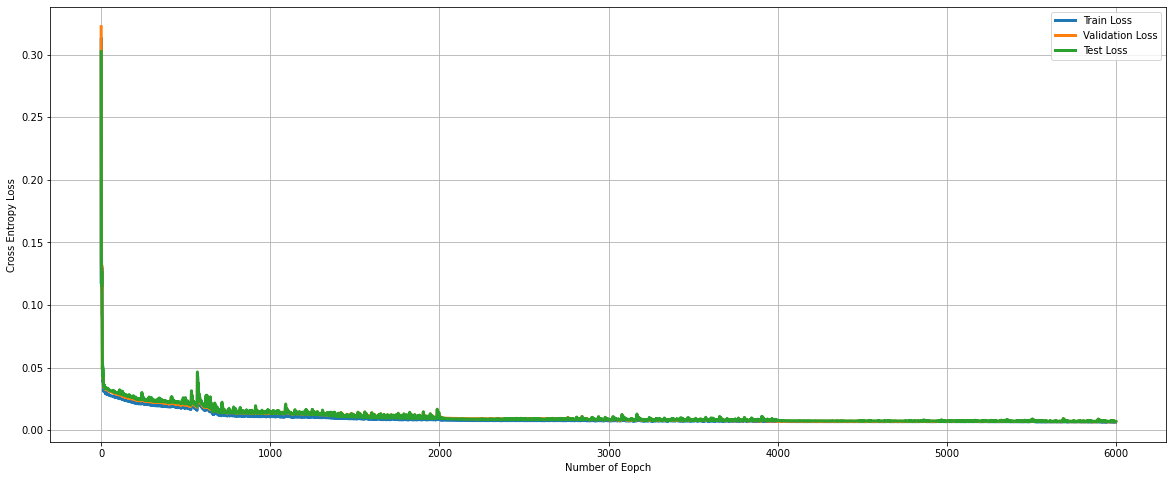

In [15]:
plot_result(train_losses, valid_losses, test_losses)